# Computer Vision, Assignment 2: Calibration and DLT

In this assignment you will study camera calibration, the projective ambiguity, and the DLT method. 

You will solve the resection and triangulation problems using DLT and compute inner parameters using RQ factorization.
In addition you will try out SIFT for feature detection/matching.

Please see Canvas for detailed instructions on what is expected for a passing/higher grade. All computer exercises not marked **OPTIONAL** are "mandatory" in the sense described on Canvas.

### Submission Requirements:
Your final lab submission should include:
1. Your edited **notebook file** (`.ipynb`).
2. An **HTML printout** of the executed notebook with all outputs visible: File → Save and export Notebook As → HTML
3. A **pdf report** containing answers to the theoretical exercises (see separate document).


In [1]:
# for creating responsive plots
%matplotlib widget  

import cv2
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.io
import scipy as sp
import random

from supplied import pflat, plot_camera

# Reuse functions from Assignment 1
from utils import *

# Calibrated vs. Uncalibrated Reconstruction

#### *Theoretical exercise 1* (see pdf)

## Computer Exercise 1
Figure 1 shows an image of a scene and a reconstruction using uncalibrated cameras. The file `compEx1data.mat` contains 
the 3D points of the reconstruction `X`, the camera matrices `P`, the image points `x` and the filenames `imfiles` of the images.
Here `X` is a $4 \times 9471$ matrix containing the homogeneous coordinates for all 3D points, `x{i}` is a $3 \times 9471$ matrix containing the homogeneous coordinates of the image points seen in image $i$ (`NaN` means that the point has not been detected in this image). `P{i}` contains the camera matrix of image $i$ and `imfiles{i}` contains the name of that image.

<figure align="center">
    <img alt="left" src="figs/DSC_0025.JPG" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="figs/projective_rec.png" width="150px">
    <figcaption>Figure 1: Left: An image of the scene. Right: A projective (uncalibrated) reconstruction.</figcaption>
</figure>

### Task 1.1
Plot the 3D points of the reconstruction. Use the supplied function `plot_camera` to plot the cameras in the same figure.

**Do the physical properties (such as the relative heights of each of the two walls, the angle in the corner, and the relation between the width, height, and depth dimensions) look realistic in the reconstruction?**

Don't forget to use `ax.set_aspect('equal')` when plotting -- otherwise you may get additional distortion. The reconstruction should look like the one shown in Figure 1.

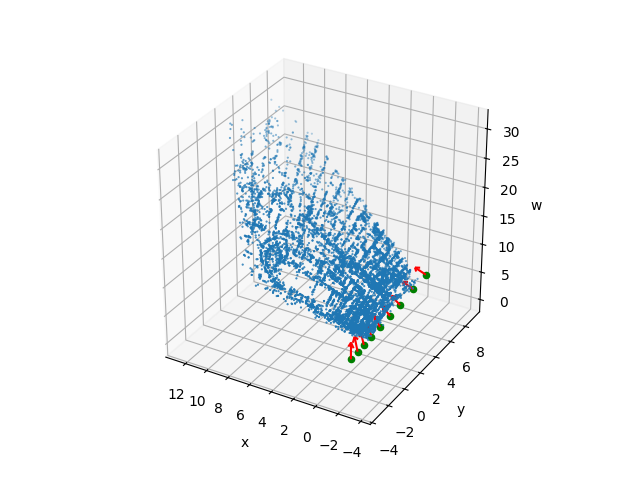

In [2]:

# ------ Your code here ------ 

data = sp.io.loadmat('data/compEx1data.mat')

X = data['X']                  # 4×9471
P = data['P'][0]               # list of camera matrices
points = data['x'][0]          # list of 3×9471 image point matrices
imfiles = data['imfiles'][0]   # list of filenames

fig = plt.figure(1)
X_cart = pflat(X)              # 4×N -> 3×N
ax = plot_points_3D(X_cart, ax=None, size=0.3)

# Plot all cameras
scale = 3
for i in range(len(P)):
    plot_camera(P[i], scale, ax=ax)

ax.set_box_aspect([1,1,1])
plt.gca().invert_xaxis()
plt.tight_layout(pad=3)
plt.show()


#### Your answer here: 

The overall reconstruction mimics the image with two walls and a window allthough the proportions are distorted. Angles between the walls seem to be approximatly 90deg but the walls appears stretched. This is expexted from this reconstruction as the true metric properties are not perserved.


### Task 1.2
Project the 3D points into **a camera** of your choice (only points that have been detected in that camera).
Plot the image, the projected points, and the image points in the same figure.

**Do the projections appear to be close to the corresponding image points?** (If not: Did you forget to divide by the third coordinate?)

**Useful python commands:**

`~np.isnan(x_i)` # to check which of the points are visible in image i

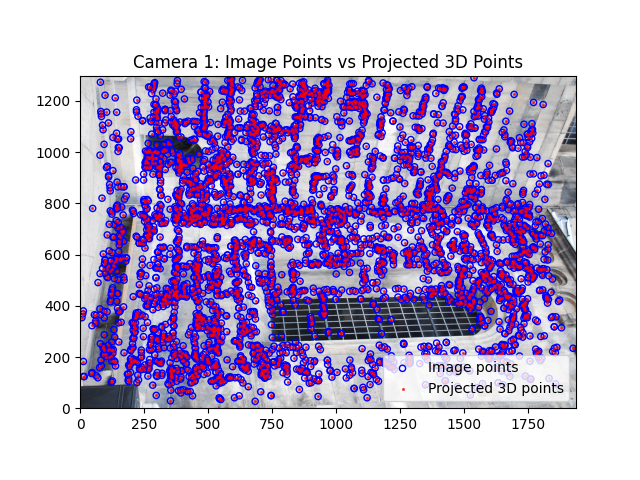

In [3]:

# ------ Your code here ------ 
n = 1

P_n = P[n]
x_n = points[n]
mask = ~np.isnan(x_n[0, :])

X_vis = X[:, mask]
x_img = x_n[:, mask]
x_proj = pflat(np.dot(P_n, X_vis))

img = plt.imread(f"data/{imfiles[n][0]}")  

plt.figure(2)
plt.imshow(img)
plt.scatter(x_img[0, :], x_img[1, :], s=20, facecolors='none', edgecolors='blue', marker='o', label='Image points')
plt.scatter(x_proj[0, :], x_proj[1, :], s=2, c='red', marker='*', alpha=0.7,label='Projected 3D points')

plt.legend()
plt.title(f"Camera {n}: Image Points vs Projected 3D Points")
plt.gca().invert_yaxis()
ax.set_aspect('equal')
plt.show()

#### Your answer here: 
The projected 3D points align well with the measured image points, the read and blue coincide with only small deviations. This indicates that the reprojection works and that the homogeneous coordinates have been normalized.


### Task 1.3
Using the two projective transformations 
\begin{equation}
T_1 = \left( \begin{array}{cccc}
1 & 0 & 0 & 0\\
0 & 3 & 0 & 0\\ 
0 & 0 & 1 & 0\\
1/8 & 1/8 & 0 & 1
\end{array} \right) \text{ and }
T_2 = \left( \begin{array}{cccc}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\ 
0 & 0 & 1 & 0\\
1/16 & 1/16 & 0 & 1
\end{array} \right),
\end{equation}

transform the 3D points ($\mathbf{X} \mapsto T_i\mathbf{X}$), and accordingly the cameras (as in *Theoretical Exercise 1*), so that two new projective solutions are obtained.

For each of the solutions, plot the 3D points and cameras in the same figure. (Don't forget to divide the points by the fourth coordinate before plotting, and again don't forget to use `ax.set_aspect('equal')`. Feel free to use the provided `pflat` function.)

**What has happened to the 3D points?**
**Does any of them appear reasonable?**

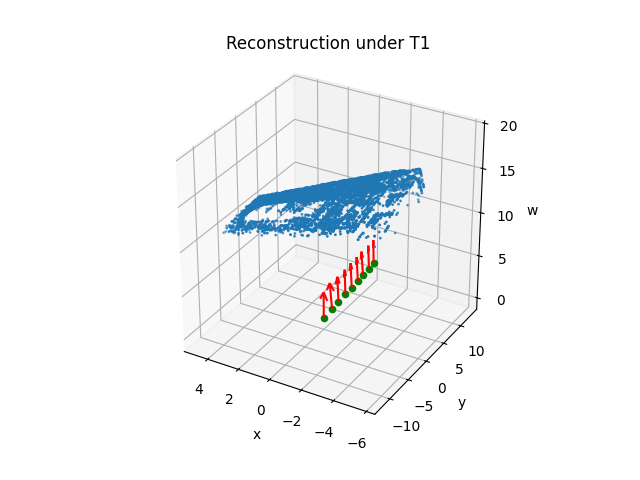

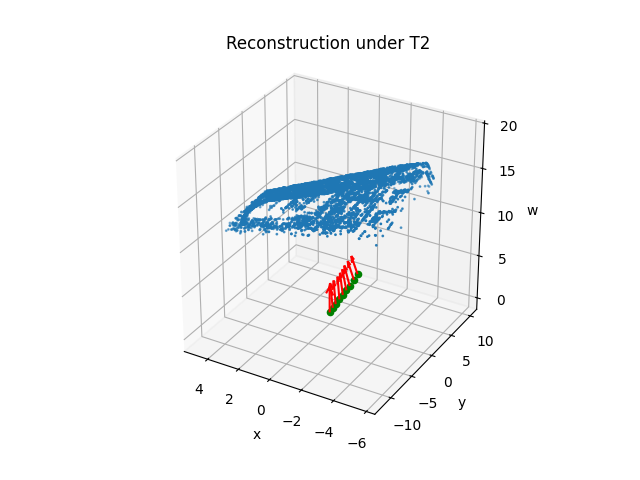

In [4]:

# ------ Your code here ------ 
T1 = np.array([[1, 0, 0, 0], [0, 3, 0, 0 ], [0, 0, 1, 0], [1/8, 1/8, 0, 1]])
T2 = np.array([[1, 0, 0, 0], [0, 1, 0, 0 ], [0, 0, 1, 0], [1/16, 1/16, 0, 1]])

X1_trans = pflat(np.dot(T1, X))
X2_trans = pflat(np.dot(T2, X))

P1_trans = [np.dot(P[i], np.linalg.inv(T1)) for i in range(len(P))]
P2_trans = [np.dot(P[i], np.linalg.inv(T2)) for i in range(len(P))]

fig = plt.figure(3)
ax = fig.add_subplot(111, projection='3d')
plot_points_3D(X1_trans, ax=ax, size=1)
for Pi in P1_trans:
    plot_camera(Pi, 3, ax=ax)
ax.invert_xaxis()
ax.set_box_aspect([1,1,1])
ax.set_title("Reconstruction under T1")
plt.show()

fig = plt.figure(4)
ax = fig.add_subplot(111, projection='3d')
plot_points_3D(X1_trans, ax=ax, size=1)
for Pi in P2_trans:
    plot_camera(Pi, 3, ax=ax)
ax.invert_xaxis()
ax.set_box_aspect([1,1,1])
ax.set_title("Reconstruction under T2")
plt.show()

### Your answer here: 

The 3D points have been distorted by transformations T1 and T2. Transformation T1 distorts the point close to the bottom of the image and produces a less realistic scen than T2 that look very reasonable.


### Task 1.4
For one of the 9 views, and for each of the new reconstructions (resulting from $T_1$ and $T_2$), project the new 3D points into its corresponding transformed camera.
Plot the pair of images along with the corresponding projected points, and the image points in the same figure. 
(Write a function `project_and_plot(P, Xs, xs, image)` that does this for you, it will be useful in the future.)

**How well do the projections and the image points align for the new reconstructions?**

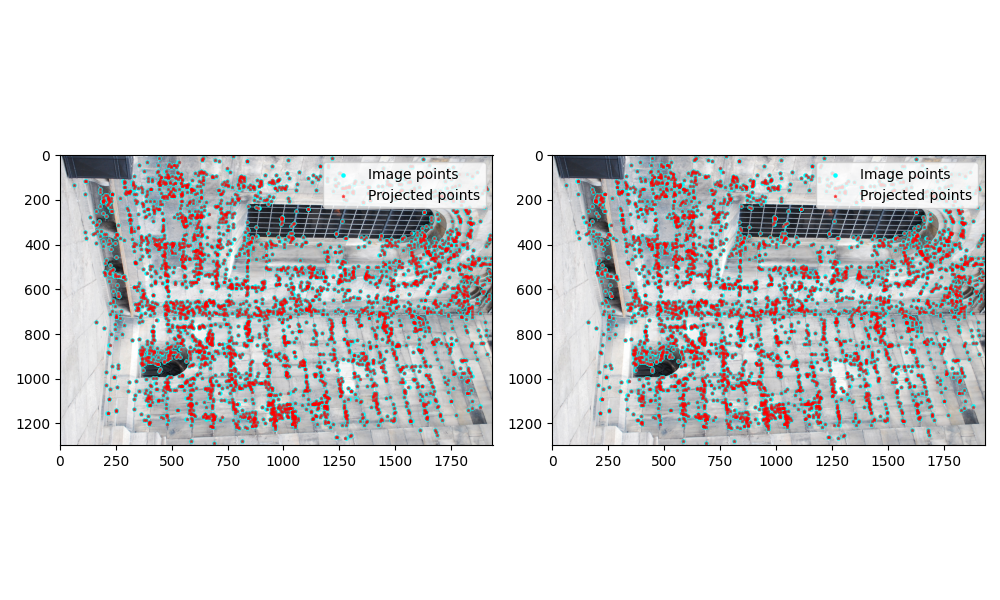

In [5]:
def project_and_plot(P, Xs, xs, image, ax):
    
    mask = ~np.isnan(xs[0, :])
    X_vis = Xs[:, mask]
    xs_vis = xs[:, mask]

    xs_proj = pflat(np.dot(P, X_vis))
    
    ax.imshow(image)
    ax.scatter(xs_vis[0], xs_vis[1], s=5, c='cyan', label="Image points")
    ax.scatter(xs_proj[0], xs_proj[1], s=3, c='red', marker='*', alpha=0.6, label="Projected points")
    #ax.invert_yaxis()
    ax.legend()

n = 0
image = plt.imread(f"data/{imfiles[n][0]}")
xs_n = points[n]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

project_and_plot(P1_trans[n], X1_trans, xs_n, image, ax1)
project_and_plot(P2_trans[n], X2_trans, xs_n, image, ax2)

plt.tight_layout()
plt.show()



#### Your answer here: 
The projections align seemingly as well as abefore. Even though the 3D points have ben transformed with T1 and T2. The re-projected points coincide well with the messured image points due to the transformation of the cameras with T^-1.

#### *Theoretical exercises: 2* (see pdf)

# Camera Calibration

#### *Theoretical exercises: 3* (see pdf)

# RQ Factorization and Computation of $K$

#### *Theoretical exercises: 4* (see pdf)

# Direct Linear Transformation DLT

#### *Theoretical exercises: 5 and 6* (see pdf)

## Computer Exercise 2
Figure 2 shows two images `cube1.JPG` and `cube2.JPG` of a scene with a Rubik's cube. 
The file `compEx2data.mat` contains a point model `Xmodel` of the visible cube sides, the measured projections `x` of the model points
in the two images and two variables `startind`, `endind` that can be used for plotting lines on the model surface.

<figure align="center">
    <img alt="left" src="figs/cube1.JPG" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="figs/cube2.JPG" width="250px">
    <figcaption>Figure 2: Two images of a scene containing a Rubik's cube.</figcaption>
</figure>

The goal for this exercise is to determine the camera for each of the two views, i.e. resectioning.
*You should consider one view at a time*, i.e. apply your code for each view separately.

### Task 2.1
Normalize the measured points by applying a transformation $N$ that subtracts the mean of the points and then re-scales the coordinates by the standard deviation.
Here, compute mean and standard deviation for $x$ and $y$ separately (separating the coordinates is not crucial, but it helps during grading if you do this in a coherent way).

Plot the normalized points in a new figure. Verify that the points are centered around $(0,0)$ with standard deviation 1 for each of the coordinates.

Remember to print out the mean and standard deviation you used for normalizing x and y, for each camera.

In [6]:
def normalize_points(x):
    x_inh = pflat(x)

    xs = x_inh[0, :]
    ys = x_inh[1, :]

    xs_mean, xs_std = np.mean(xs), np.std(xs)
    ys_mean, ys_std = np.mean(ys), np.std(ys)

    # Normalization matrix
    N = np.array([[1/xs_std, 0, -xs_mean/xs_std], 
                 [0, 1/ys_std, -ys_mean/ys_std], 
                 [0, 0, 1]])

    # Normalize
    x_norm = np.dot(N, x)

    return x_norm, N, (xs_mean, ys_mean, xs_std, ys_std)

Camera 1:
  mean_x =  1014.8534   std_x =   193.9348
  mean_y =   839.0383   std_y =   195.8207

Camera 2:
  mean_x =   930.9657   std_x =   195.7145
  mean_y =   795.1860   std_y =   196.7225


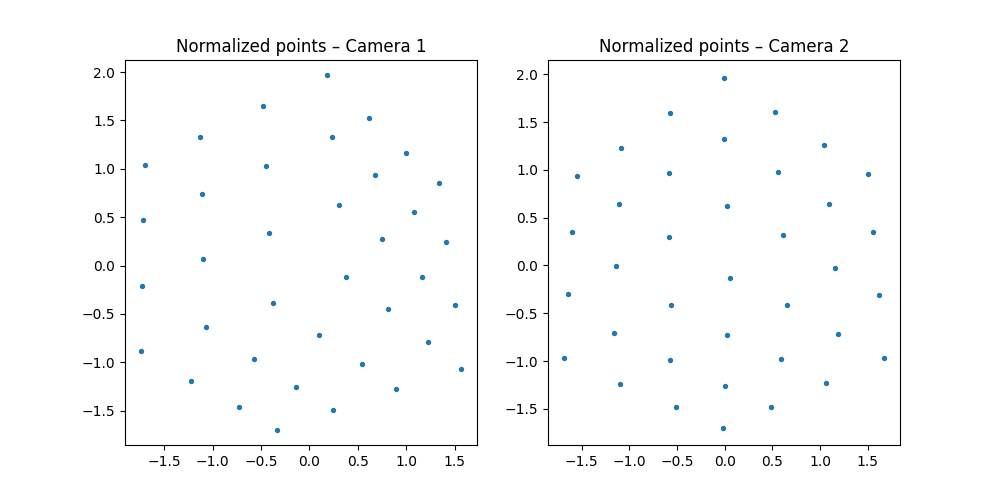

In [7]:

# ------ Your code here ------ 
img1 = plt.imread('data/cube1.jpg')
img2 = plt.imread('data/cube2.jpg')

data = sp.io.loadmat('data/compEx2data.mat')
Xmodel = data['Xmodel']                   # Point model of cube sides - 3x37
x = data['x']                             # Messured projections of model points - 1x2
start_ind = data['startind']              # 126x1
end_ind = data['endind']                  # 126x1

x1, x2 = x[0, 0], x[0, 1]

# Camera 1
x1_norm, N1, stats1 = normalize_points(x1)
mean_x1, mean_y1, std_x1, std_y1 = stats1
print(f"Camera 1:")
print(f"  mean_x = {mean_x1:10.4f}   std_x = {std_x1:10.4f}")
print(f"  mean_y = {mean_y1:10.4f}   std_y = {std_y1:10.4f}")

# Camera 2
x2_norm, N2, stats2 = normalize_points(x2)
mean_x2, mean_y2, std_x2, std_y2 = stats2
print(f"\nCamera 2:")
print(f"  mean_x = {mean_x2:10.4f}   std_x = {std_x2:10.4f}")
print(f"  mean_y = {mean_y2:10.4f}   std_y = {std_y2:10.4f}")

# Plot
plt.figure(6, figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(x1_norm[0,:], x1_norm[1,:], s=8)
plt.title("Normalized points – Camera 1")
plt.axis('equal')

plt.subplot(1,2,2)
plt.scatter(x2_norm[0,:], x2_norm[1,:], s=8)
plt.title("Normalized points – Camera 2")
plt.axis('equal')

plt.show()


### Task 2.2
Implement a function `estimate_camera_DLT` that sets up the DLT equations for resectioning, and solves the resulting homogeneous least squares system using SVD.

$$\min_{||v||^2 = 1}||Mv||^2$$

**Is the smallest singular value close to zero? How about $||Mv||$?**


**Useful python commands:**

`U, S, Vt = np.linalg.svd(M)` # compute SVD of a matrix

In [8]:
'''
    The DLT system from Szeliski give:
    ui * p3.T * Xi =  p1.T * Xi
    vi * p3.T * Xi =  p2.T * Xi

    Expanding into standard formulation we get:
    [-Xi 0 uiXi]' [p1, p2, p3] = 0
    [0  -Xi viXi]' [p1, p2, p3] = 0
'''
def estimate_camera_DLT(x, Xmodel):
    # Your code here
        
    if Xmodel.shape[0] == 3:
        X_h = np.vstack([Xmodel, np.ones((1, Xmodel.shape[1]))])
    else:
        X_h = Xmodel

    x_inh = pflat(x)

    N = x.shape[1]                                  
    M = []

    for i in range(N):
        u, v, w = x_inh[:, i]
        Xi = X_h[:, i]
        
        M.append(np.hstack([-Xi, np.zeros(4), u*Xi]))
        M.append(np.hstack([np.zeros(4) , -Xi,  v*Xi]))
    
    M = np.array(M)

    # Solve M v = 0 using SVD
    U, S, Vt = np.linalg.svd(M)
    v = Vt[-1, :]                  
    P = v[:12].reshape(3,4) 

    if np.mean(np.dot(P, X_h)[2, :]) < 0:
        P = -P
          
    min_sv = S[-1]
    residual = np.linalg.norm(np.dot(M, v))

    print(f"Smallest singular value:     {min_sv:.6e}")
    print(f"Residual ||M v||:            {residual:.6e}")

    return P, M, S 

#### Your answer here: 
Camera 1: Smallest singular value: 5.103414e-02, Residual ||M v||: 5.103414e-02

Camera 2
Smallest singular value:4.378218e-02, Residual ||M v||: 4.378218e-02

The smallest singular values are small and close to zero and the residuals match them.


### Task 2.3
Extract the entries of the camera from the solution and set up the camera matrix.
Make sure that you select the solution where the points are in front of the camera.
(If $X$ has 4th coordinate 1 then the 3rd coordinate of $PX$ should be positive for $X$ to be in front of the camera.)

Project the model points into the images. (Don't forget to transform the camera matrix to the original (un-normalized) coordinate system, as in *Theoretiacl Exercise 6*, before projecting.) Plot the measured image points in the same figure. **Are they close to each other?** Also make a 3D plot visualizing the camera centers, principal axes, as well as the 3D model points.
**Does the result look reasonable?**

Smallest singular value:     5.103414e-02
Residual ||M v||:            5.103414e-02
Smallest singular value:     4.378218e-02
Residual ||M v||:            4.378218e-02


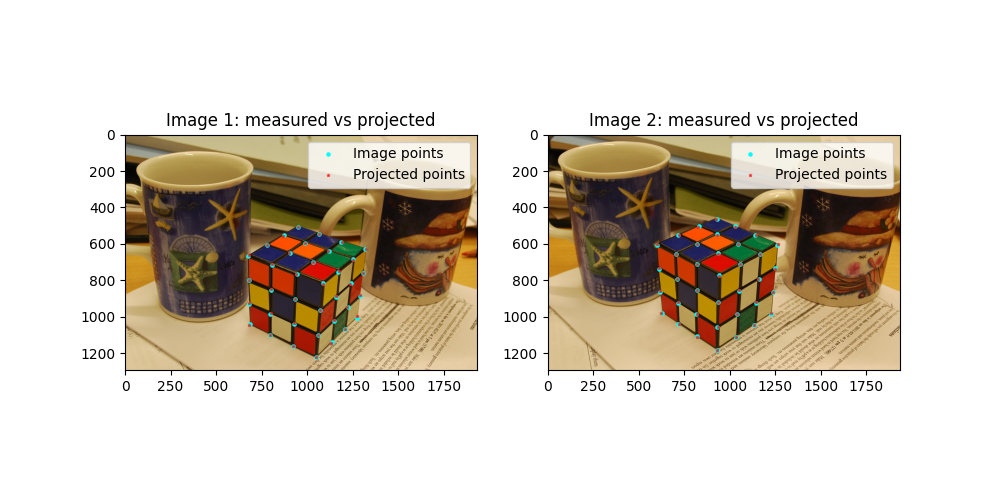

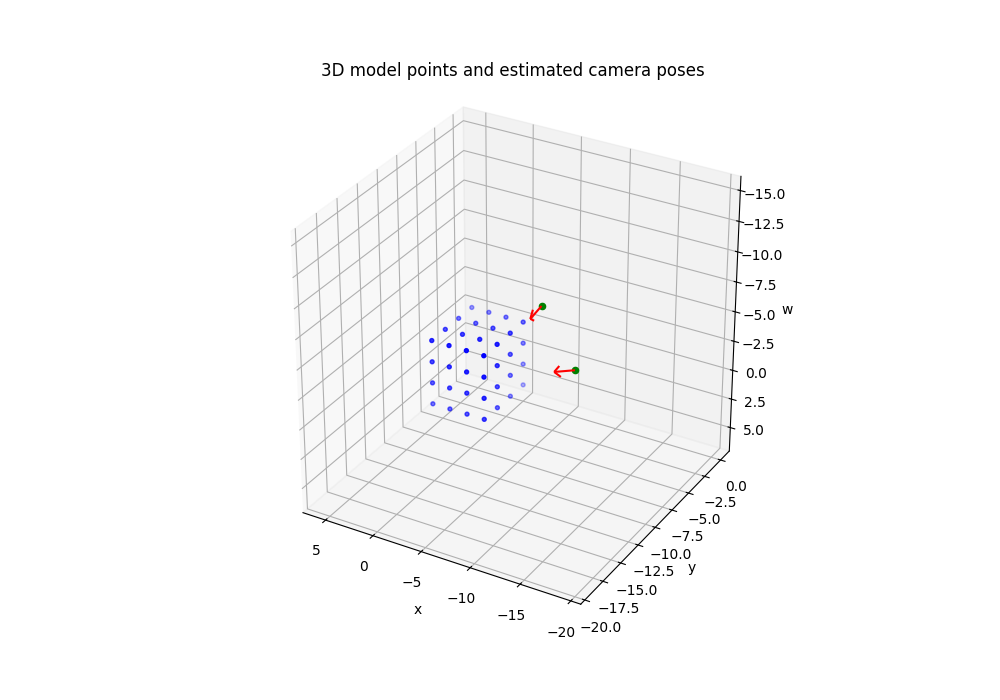

In [9]:

# ------ Your code here ------


# extract the camera matrices
P1_est, M1, _ = estimate_camera_DLT(x1_norm, Xmodel)
P2_est, _, _ = estimate_camera_DLT(x2_norm, Xmodel)        

#print(P1_est, P2_est)

# Project and plot the models points into the images
P1 = np.dot(np.linalg.inv(N1), P1_est)
P2 = np.dot(np.linalg.inv(N2), P2_est)

if Xmodel.shape[0] == 3:
    X_h = np.vstack([Xmodel, np.ones((1, Xmodel.shape[1]))])
else:
    X_h = Xmodel

x1_proj = pflat(np.dot(P1,X_h))
x2_proj = pflat(np.dot(P2, X_h))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
project_and_plot(P1, X_h, x1, img1, ax1)
ax1.set_title("Image 1: measured vs projected")

project_and_plot(P2, X_h, x2, img2, ax2)
ax2.set_title("Image 2: measured vs projected")
plt.show()


# Make a 3D plot with 3D model points, camera centers, and principal axes
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot model points
plot_points_3D(X_h, ax=ax, size=8, kwargs={'c':'blue'})

# Plot both cameras using your helper
plot_camera(P1, scale=5, ax=ax)
plot_camera(P2, scale=5, ax=ax)

ax.set_title("3D model points and estimated camera poses")
ax.invert_xaxis()
ax.invert_zaxis()
plt.show()

### Your answer here: 
The measured and projected points align fairly well in both images but with some minor projection errors in certain points.

The camera and cube 3D plot visualization looks reasonable and matches the actuall setup.


### Task 2.4
Compute the inner parameters of the first camera using RQ decomposition. 

**How can we know that these are the "true" parameters? Why is there no ambiguity as in Theoretical Exercise 1?**

Please also print out the calibration matrix of the first camera, normalized s.t. $K_{33}=1$.

When you have achieved satisfactory results, save the camera matrices (for both views) to be used in further exercises.

**Useful python commands:**

`scipy.linalg.rq(P)` # compute the RQ decomposition of a matrix

In [10]:

# ------ Your code here ------
def decompose_camera_matrix(P):
    A = P[:, :3]
    t = P[:, 3]

    # RQ decomp:
    K, R = sp.linalg.rq(A)
    
    T = np.diag(np.sign(np.diag(K)))
    K = np.dot(K, T)
    R = np.dot(T, R)
    
    K /= K[2,2]
    C = np.dot(-np.linalg.inv(A), t)

    return K, R, C

K1, R1, C1 = decompose_camera_matrix(P1)
K2, R2, C2 = decompose_camera_matrix(P2)

print("K1:\n", K1)
print("R1:\n", R1)
print("Camera center 1:\n", C1)

K1:
 [[ 2.42183633e+03 -6.77588216e+00  9.80194001e+02]
 [ 0.00000000e+00  2.42003888e+03  6.93975417e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R1:
 [[ 0.55488446 -0.04823084 -0.83052816]
 [-0.37929667  0.87385433 -0.30415893]
 [ 0.74043047  0.48378963  0.46659439]]
Camera center 1:
 [-19.16324782 -19.15717865 -10.65766915]


### Your answer here: 

These parameters are unique because the calibration uses a 3D object with known Euclidean coordinates. The camera matrix must map these real-world points to their measured image positions, which fixes the solution in metric space. Once $\mathbf{P}$ is estimated, its decomposition into $\mathbf{K}[\mathbf{R}\,|\,\mathbf{t}]$ is uniquely determined.

In Theoretical Exercise 1, both the cameras and the 3D structure were unknown, so the entire configuration could be altered by an arbitrary projective transformation without affecting the image projections. Here, the known 3D geometry removes that freedom, eliminating the ambiguity.


### Task 2.5 (OPTIONAL, 10 optional points)
You will now re-run your experiments in a few different settings to be compared, investigating the importance of normalization. You only need to do this part for **the first view** (corresponding to 2D points `x{1}`). For each experiment, measure the performance with the RMS error 

$$
\begin{equation}
e_{RMS} = \sqrt{ \frac{1}{n} ||x_{meas} - x_{proj}||_F^2 },
\end{equation}
$$

where $x_{meas}$, $x_{proj}$ are the Cartesian coordinates ($2\times n$-matrices) for the measured points and projected model points respectively, and $n$ is the number of points. Here $|| \cdot ||_F^2$ denotes the (squared) Frobenius norm.

**Useful python commands:**

`np.linalg.norm(dx, 'fro') ** 2` # compute the squared Frobenius norm

In [11]:
def e_rms(x_measured, x_projected):
    # Your code here
    pass

First compute RMS values when using normalization (as you have done so far).
Next, repeat the whole resectioning experiment one more time, but this time don't normalize the points. (The easiest way of doing this is probably to use $N=I$ as normalization matrix and run the same code again.)

**Is the difference large?** 

Report the RMS number and explain your findings.

In [12]:

# ------ Your code here ------


### Your answer here: 

(*Include answers to all questions marked in bold.*)
#

Now repeat the resectioning experiments (with and without normalization), but this time estimate the camera using only points number $1,4,13,16,25,28,31$. Still, measure the RMS error in a unified way, always using all points!.

**What can you conclude from the experiments that you have run?**

In [13]:

# ------ Your code here ------



### Your answer here: 

(*Include answers to all questions marked in bold.*)
#

# Feature Extraction and Matching using SIFT

## Computer Exercise 3
In this exercise you will get to try feature extraction using SIFT.

You will need `OpenCV` package for computing SIFT features so first make sure that you have the package installed and successfully imported. 

### Task 3.1
First load the images `cube1.jpg` and `cube2.jpg` from Computer Exercise 2. We will work with **grayscale** images for SIFT.

Compute SIFT features using OpenCV’s implementation of SIFT. 

**Useful python commands:**

`sift = cv2.SIFT_create(contrastThreshold=0.01)` # initialize a sift detector

`keypoints1, descriptors1 = sift.detectAndCompute(im1, None)` # compute keypoints and descriptors


The SIFT detector searches for peaks in scale space (similar to peaks in the autocorrelation function, see lecture notes). The `contrastThreshold` parameter filters out weak peaks.

The variable `keypoints1` contains a list of detected features `kp`. Each keypoint has: 
- `kp.pt` -- $(x, y)$ coordinates
- `kp.angle` -- an orientation
- `kp.size` -- a scale

and the descriptor in `descriptors1` encodes local image information around that point.


In [14]:

# ------ Your code here ------

# load images in greyscale
img1 = cv2.imread('data/cube1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('data/cube2.jpg', cv2.IMREAD_GRAYSCALE)

# compute keypoints and descriptors for both images
sift = cv2.SIFT_create(contrastThreshold=0.01)
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

Visualize the detected keypoints with the images.
```
im1_kp = cv2.drawKeypoints(im1, keypoints1, None,
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
```


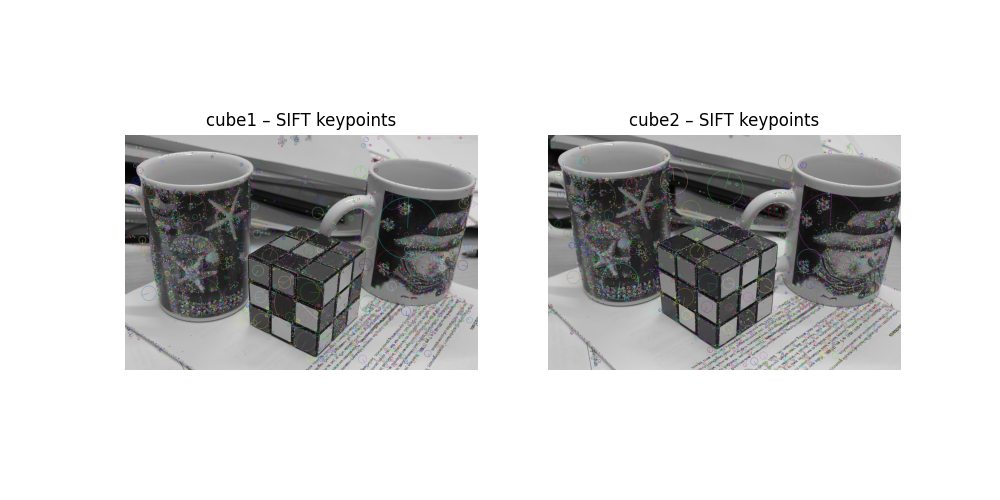

In [15]:

# ------ Your code here ------
im1_kp = cv2.drawKeypoints(img1, keypoints1, None,
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

im2_kp = cv2.drawKeypoints(img2, keypoints2, None,
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(im1_kp)
ax1.set_title("cube1 – SIFT keypoints")
ax1.axis("off")

ax2.imshow(im2_kp)
ax2.set_title("cube2 – SIFT keypoints")
ax2.axis("off")

plt.show()


### Task 3.2
We now want to find correspondences between the two sets of SIFT descriptors.

```
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(descriptors1, descriptors2, k=2)
```

For each descriptor in the first image, `bf.knnMatch.knnMatch()` returns `k` best matches in the second image, where `k=2` by default. 

However, sometimes a feature may have two or more similarly good matches, especially in textured or repetitive regions — these are ambiguous and should not be trusted.

We can apply **Lowe's ratio test** to filter out these ambiguous matches by comparing the distance of the best match (`m`) to the second-best match (`n`) and keep only the matches if the best match is much better than the second best (e.g. `m.distance < 0.75 * n.distance`).

Otherwise, both matches are almost equally good, the match is ambiguous, and we should reject it.

In [16]:

# ------ Your code here ------

        
# Compute matches between descriptors1 and descriptors2
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(descriptors1, descriptors2, k=2)


# Apply Lowe's ratio test to filter out the ambiguous mathes
ratio_thresh = 0.75
good_matches = []

for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

print(f"Total raw matches: {len(matches)}")
print(f"Good matches after ratio test: {len(good_matches)}")
print(f"Percentage kept: {100 * len(good_matches) / len(matches):.1f}%")

Total raw matches: 13147
Good matches after ratio test: 2895
Percentage kept: 22.0%


### Task 3.3
We can now extract matching points as follows. (Note that you will need the point sets $x1$ and $x2$ for the next exercise.)
```
x1 = np.array([keypoints1[m.queryIdx].pt for m in good_matches]).T
x2 = np.array([keypoints2[m.trainIdx].pt for m in good_matches]).T
```

Randomly select 10 matches, plot the two images next to each other and plots lines between the matching points.

**How many of the matches appear to be correct?**

**Useful python commands:**

```
im_matches = cv2.drawMatchesKnn(im1, keypoints1,
                                im2, keypoints2,
                                selected_matches, None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
```

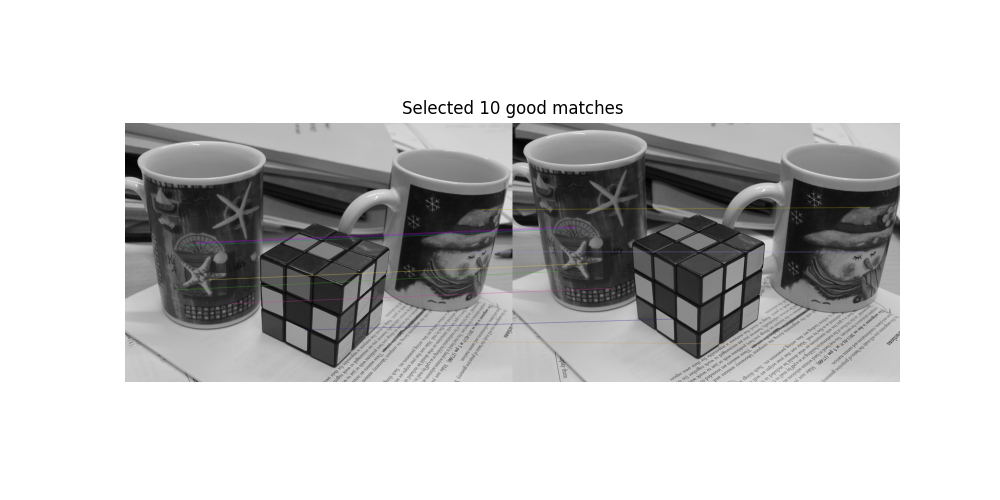

In [17]:

# ------ Your code here ------

x1 = np.array([keypoints1[m.queryIdx].pt for m in good_matches]).T
x2 = np.array([keypoints2[m.trainIdx].pt for m in good_matches]).T

# Extract matching points
num_samples = 10
selected_samples = random.sample(good_matches, num_samples)




# Plot matching points on the two images
im_matches = cv2.drawMatches(img1, keypoints1,
                                img2, keypoints2,
                                selected_samples, None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(im_matches, cv2.COLOR_BGR2RGB))
plt.title("Selected 10 good matches")
plt.axis('off')
plt.show()


### Your answer here: 

In the 10 selected matches they all appear to be correct as the lines connect to corresponding points in both images, at least no obvious mismatches are visable.

# Triangulation using DLT

## Computer Exercise 4
Using the estimated cameras from Computer Exercise 2 you will now triangulate the points detected in Computer Exercise 3.

### Task 4.1
Implement a function `triangulate_3D_point_DLT` that set ups the DLT equations for triangulation, and solves the homogeneous least squares system.
(You will have to do this in a loop, once for each point.)

In [18]:
def triangulate_3D_point_DLT(x1, x2, P1, P2):
    # Your code here

    # homogeneous image points
    x1_h = np.array([x1[0], x1[1], 1.0])
    x2_h = np.array([x2[0], x2[1], 1.0])

    A = np.vstack([
        x1_h[0] * P1[2, :] - P1[0, :],
        x1_h[1] * P1[2, :] - P1[1, :],
        x2_h[0] * P2[2, :] - P2[0, :],
        x2_h[1] * P2[2, :] - P2[1, :],
    ])

    _, _, Vt = np.linalg.svd(A)
    X_h = Vt[-1, :]
    
    return X_h / X_h[-1]     

Project the computed points into the two images and compare with the corresponding SIFT-points in a 2D plot.

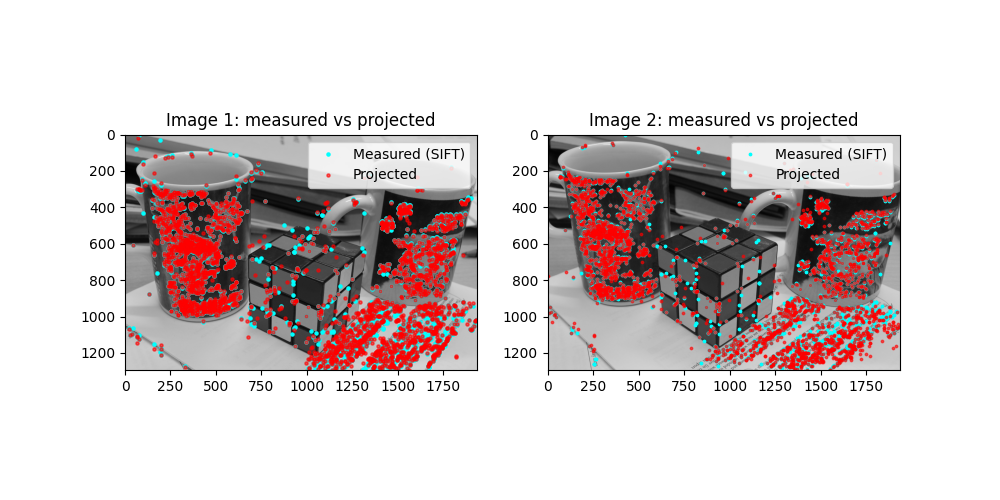

In [19]:

# ------ Your code here ------

# Compute the 3D points
num_points = x1.shape[1]
X_est = np.zeros((4, num_points))  

X_list = []

for i in range(x1.shape[1]):
    Xh = triangulate_3D_point_DLT(x1[:, i], x2[:, i], P1, P2)
    X_list.append(Xh)

X = np.array(X_list).T    # Make it 4×N
X_cart = pflat(X)

x1_proj = pflat(np.dot(P1, X))   
x2_proj = pflat(np.dot(P2, X))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Image 1
ax1.imshow(img1, cmap='gray')
ax1.scatter(x1[0, :], x1[1, :], s=5, c='cyan', label='Measured (SIFT)')
ax1.scatter(x1_proj[0, :], x1_proj[1, :], s=5, c='red', alpha=0.6, label='Projected')
ax1.set_title("Image 1: measured vs projected")
ax1.set_xlim(0, img1.shape[1])
ax1.set_ylim(img1.shape[0], 0)   # y downwards
ax1.legend()

# Image 2
ax2.imshow(img2, cmap='gray')
ax2.scatter(x2[0, :], x2[1, :], s=3, c='cyan', label='Measured (SIFT)')
ax2.scatter(x2_proj[0, :], x2_proj[1, :], s=3, c='red', alpha=0.6, label='Projected')
ax2.set_title("Image 2: measured vs projected")
ax2.set_xlim(0, img2.shape[1])
ax2.set_ylim(img2.shape[0], 0)
ax2.legend()

plt.show()


### Task 4.2
Now, re-run the triangulation, but first normalize 2D points and cameras using the inverse of $K$. Again, compare with the SIFT points in a plot.
Just as when normalizing with $N$ (based on mean/std) for the resection problem in Computer Exercise 2, how is your result for triangulation from normalization compared to the result without normalization? Note that using $K$ or $N$ for normalization doesn't matter much, but $K$ was not available for the previous problem (resection).

[[ 0.0084848  -0.0007375  -0.0126997   0.01311866]
 [-0.00579987  0.0133622  -0.00465093  0.09526975]
 [ 0.011322    0.00739768  0.00713475  0.43472476]]


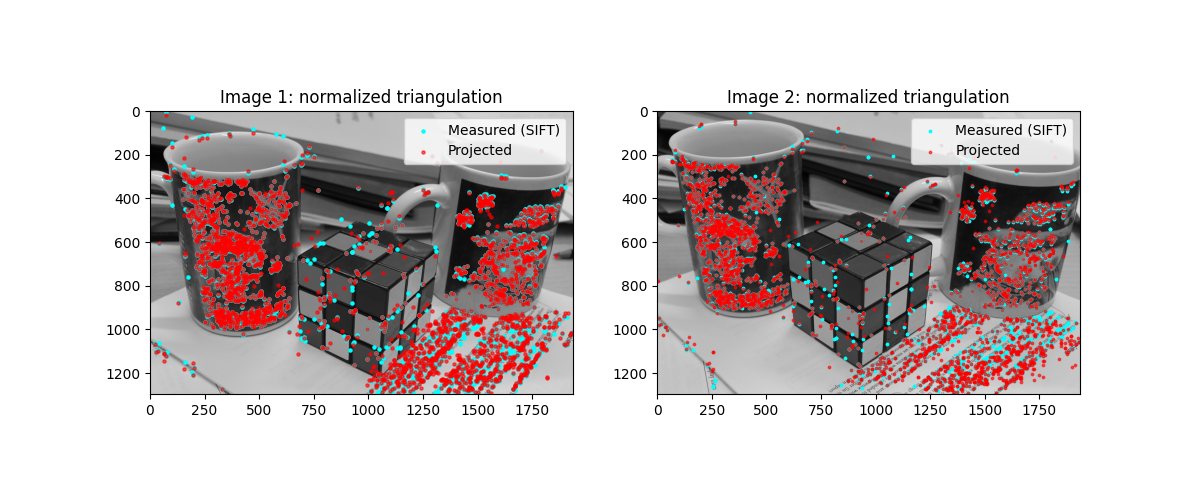

In [25]:
# ------ Your code here ------

# 1) Homogeneous pixel coordinates of SIFT matches
x1_h = pflat(x1)   # 3×N
x2_h = pflat(x2)   # 3×N

# 2) Normalize image points with intrinsics
K1_inv = np.linalg.inv(K1)
K2_inv = np.linalg.inv(K2)

# 1) Homogeneous pixel coordinates (3×N)
x1_h = np.vstack([x1, np.ones((1, x1.shape[1]))])
x2_h = np.vstack([x2, np.ones((1, x2.shape[1]))])

x1_normK = K1_inv @ x1_h   
x2_normK = K2_inv @ x2_h   

# 3) Normalize the camera matrices: P = K [R|t] -> P_norm = [R|t]
P1_norm = K1_inv @ P1
P2_norm = K2_inv @ P2

# 4) Triangulate in normalized coordinates
num_points = x1_normK.shape[1]
X_est = np.zeros((4, num_points))

for i in range(num_points):
    X_est[:, i] = triangulate_3D_point_DLT(
        x1_normK[0:2, i],
        x2_normK[0:2, i],
        P1_norm,
        P2_norm
    )

x1_proj = pflat(P1 @ X_est)
x2_proj = pflat(P2 @ X_est)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(img1, cmap='gray')
ax1.scatter(x1[0, :], x1[1, :], s=5, c='cyan', label='Measured (SIFT)')
ax1.scatter(x1_proj[0, :], x1_proj[1, :], s=5, c='red', alpha=0.6, label='Projected')
ax1.set_xlim(0, img1.shape[1])
ax1.set_ylim(img1.shape[0], 0)
ax1.set_title("Image 1: normalized triangulation")
ax1.legend()

ax2.imshow(img2, cmap='gray')
ax2.scatter(x2[0, :], x2[1, :], s=3, c='cyan', label='Measured (SIFT)')
ax2.scatter(x2_proj[0, :], x2_proj[1, :], s=3, c='red', alpha=0.6, label='Projected')
ax2.set_xlim(0, img2.shape[1])
ax2.set_ylim(img2.shape[0], 0)
ax2.set_title("Image 2: normalized triangulation")
ax2.legend()

plt.show()


### Task 4.3
From now on, consider only the normalized case.

As we saw in Computer Exercise 3, a portion of the SIFT matches will be incorrect. Most of the time (but not always) this will result in triangulations with large error.
Compute the average pixel error (for each of the two images) between the projected 3D points and the corresponding SIFT points (remember to multiply with $K$ to retrieve pixel coordinates rather than normalized coordinates).

Remove those points for which the error in at least one of the images is larger than $3$ pixels.
Plot the remaining 3D points, the cameras and the cube model in one and the same 3D plot. 

**Can you distinguish the dominant objects (the cups and the paper)?**

Mean reprojection error img1 (all points): 336.2294715596441
Mean reprojection error img2 (all points): 28.615771256250042
Max reprojection error img1: 897506.2344895793
Max reprojection error img2: 19575.41304746539

Number of inliers: 2212 / 2895


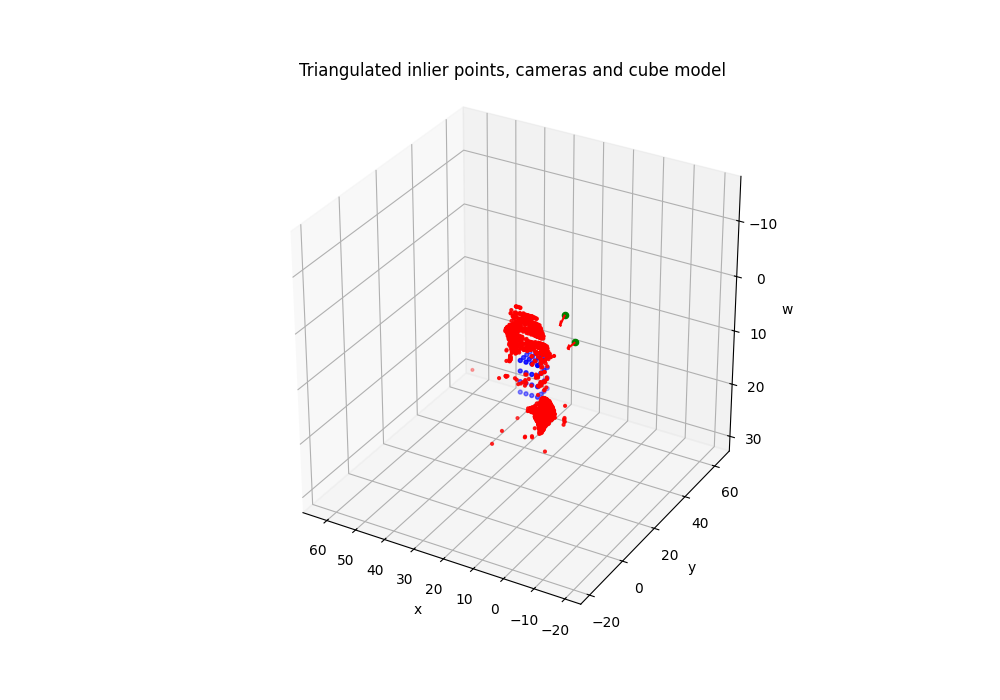

In [21]:

# ------ Your code here ------

x1_proj_2d = x1_proj[0:2, :] / x1_proj[2, :]
x2_proj_2d = x2_proj[0:2, :] / x2_proj[2, :]

err1 = np.linalg.norm(x1 - x1_proj_2d, axis=0)
err2 = np.linalg.norm(x2 - x2_proj_2d, axis=0)


print("Mean reprojection error img1 (all points):", err1.mean())
print("Mean reprojection error img2 (all points):", err2.mean())
print("Max reprojection error img1:", err1.max())
print("Max reprojection error img2:", err2.max())

# 2) Inlier mask: keep points with <= 3 px error in BOTH images
threshold = 3.0
inliers = (err1 <= threshold) & (err2 <= threshold)

print(f"\nNumber of inliers: {inliers.sum()} / {X_est.shape[1]}")

X_inliers = X_est[:, inliers]

# 3) Prepare cube model in homogeneous coords
if Xmodel.shape[0] == 3:
    Xmodel_h = np.vstack([Xmodel, np.ones((1, Xmodel.shape[1]))])
else:
    Xmodel_h = Xmodel

# 4) 3D plot: cube model + cameras + triangulated inliers
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Cube model (blue)
plot_points_3D(Xmodel_h, ax=ax, size=8, kwargs={'c': 'blue'})

# Inlier triangulated SIFT points (red)
plot_points_3D(X_inliers, ax=ax, size=4, kwargs={'c': 'red'})

# Cameras
plot_camera(P1, scale=5, ax=ax)
plot_camera(P2, scale=5, ax=ax)

ax.set_title("Triangulated inlier points, cameras and cube model")
ax.invert_xaxis()
ax.invert_zaxis()
plt.show()



### Your answer here: 

Its not possible to distingush which object it is by just looking, but when compared to the image we can find dominant objects such as the cups and paper.